# Example of usage Spark OCR for Tables Recognition

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

imagePath = "./data/tab_images_hocr_1/*.jpg"
imagePath_2 = "./data/tab_images_hocr_2/*.jpg"
imagePath_3 = "./data/tab_images_hocr_3/*.png"

In [8]:
# NBVAL_SKIP
import os
os.environ['SPARK_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_key

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [2]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

spark = start(jar_path=spark_ocr_jar_path)
spark

Spark version: 3.4.1
Spark NLP version: 5.1.2
Spark OCR version: 5.1.2rc5



## Printed source
### Read images and display it

In [3]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


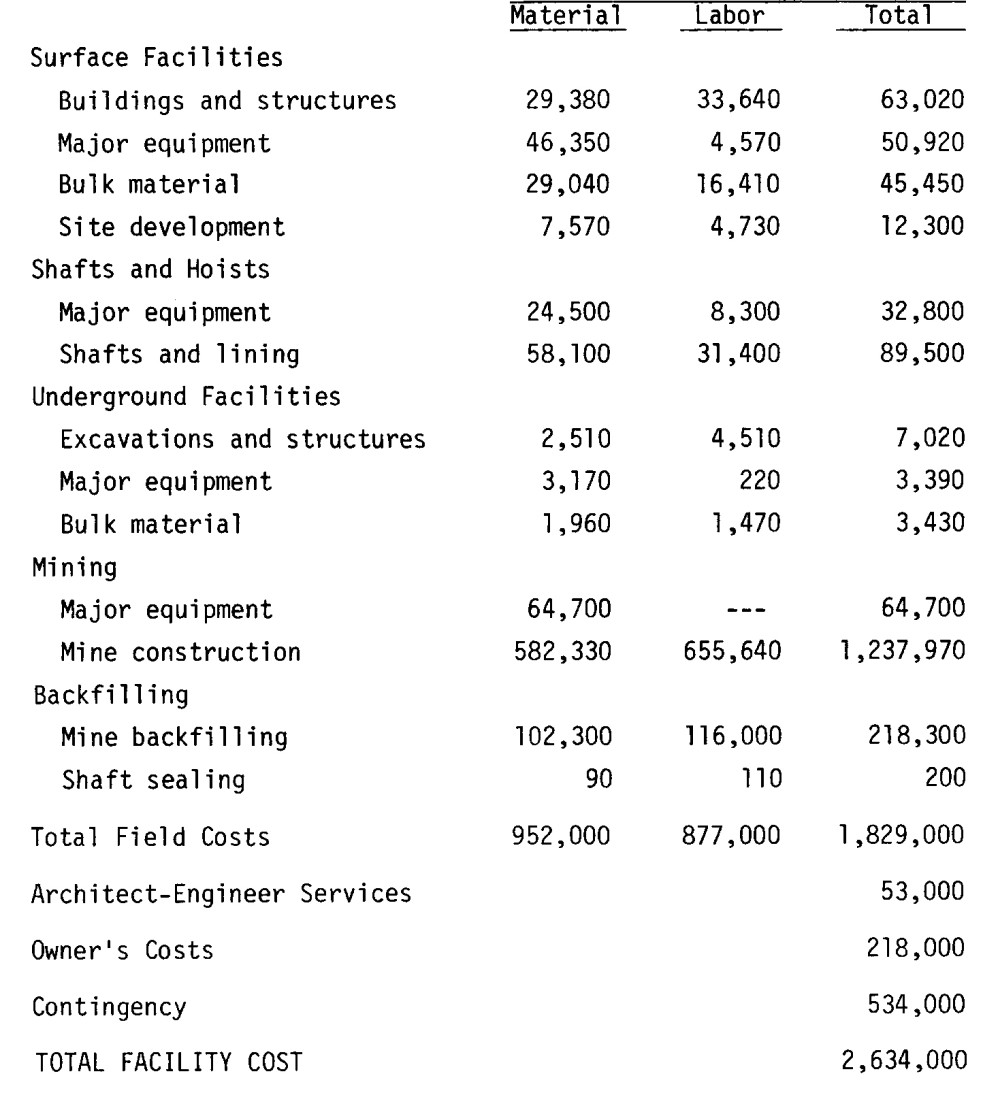

In [4]:
image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

In [5]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

img_to_hocr = ImageToTextV2().pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setUseGPU(False)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+
|        text_regions|                path|    modificationTime|length|pagenum|         table_image|       table_regions|               image|  image_with_regions|                hocr|positions|              tables|exception|table_index|
+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+
|[{0, 0, 566.32025...|file:/home/jose/s...|2023-05-26 14:22:...|172124|      0|{file:/home/jose/...|{0, 0, 40.0, 0.0,...|{file:/home/jose/...|{file:/home/jose/...|<div title="bbox ...|   [null]|{{0, 0, 0.0, 0.0,...|     null|          0|
+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+

### Show text regions


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


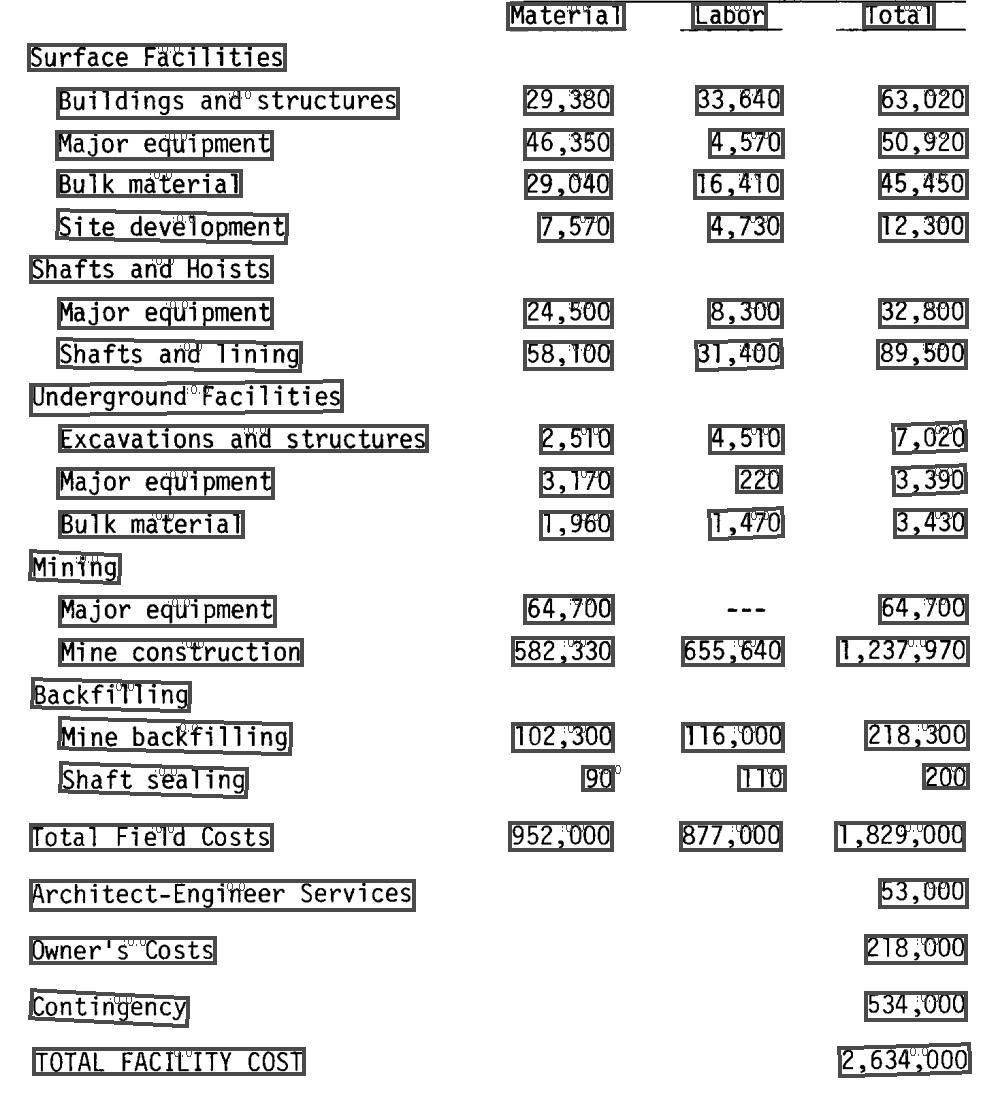

In [6]:
display_images(result, "image_with_regions")

### Show images with tables


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 937 px
    Height: 1093 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


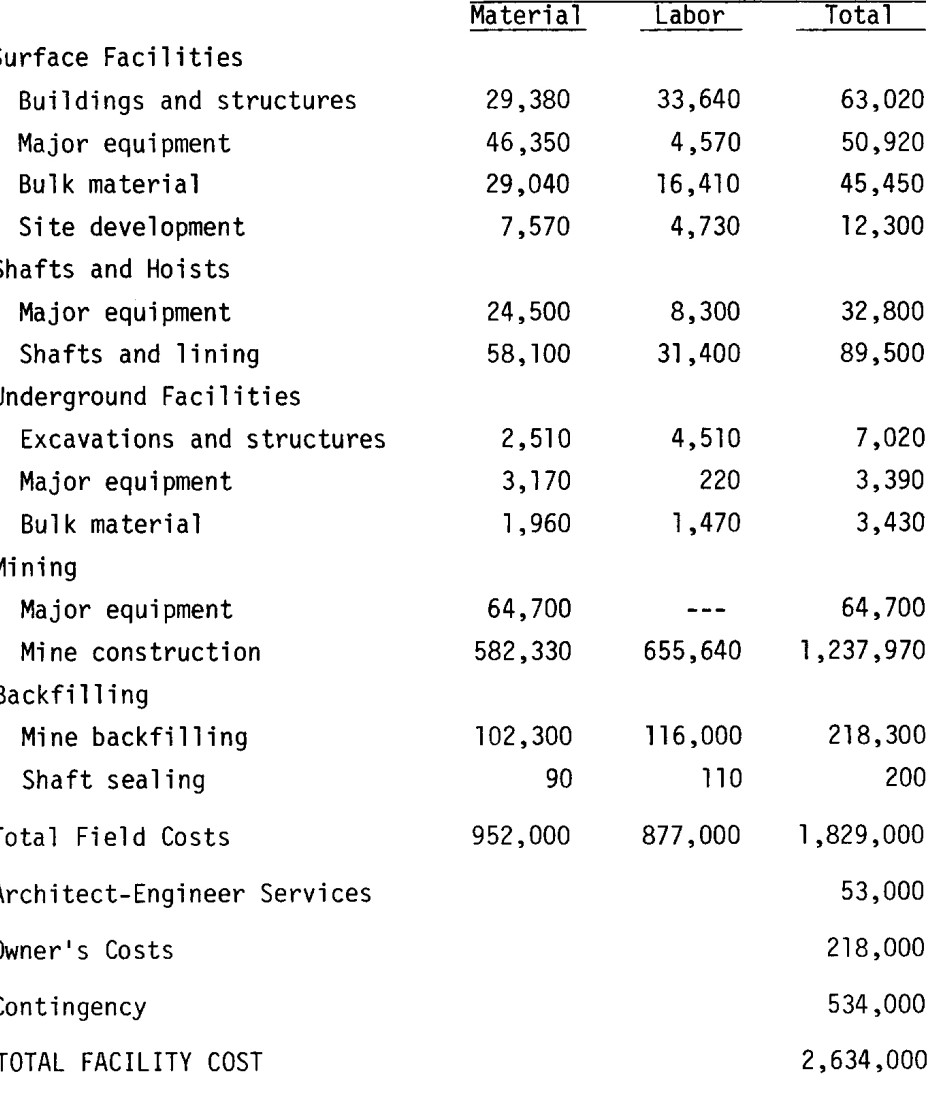

In [7]:
display_images(result, "table_image")

### Display recognized tables

In [8]:
result.select("tables")

+--------------------+
|              tables|
+--------------------+
|{{0, 0, 0.0, 0.0,...|
+--------------------+

In [9]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: table4_1.jpg
Page: 0
Table: 0
Number of Columns: 4


## Handwritten source


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_2/cTDaR_t00192.jpg
    Resolution: 0 dpi
    Width: 2731 px
    Height: 4096 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


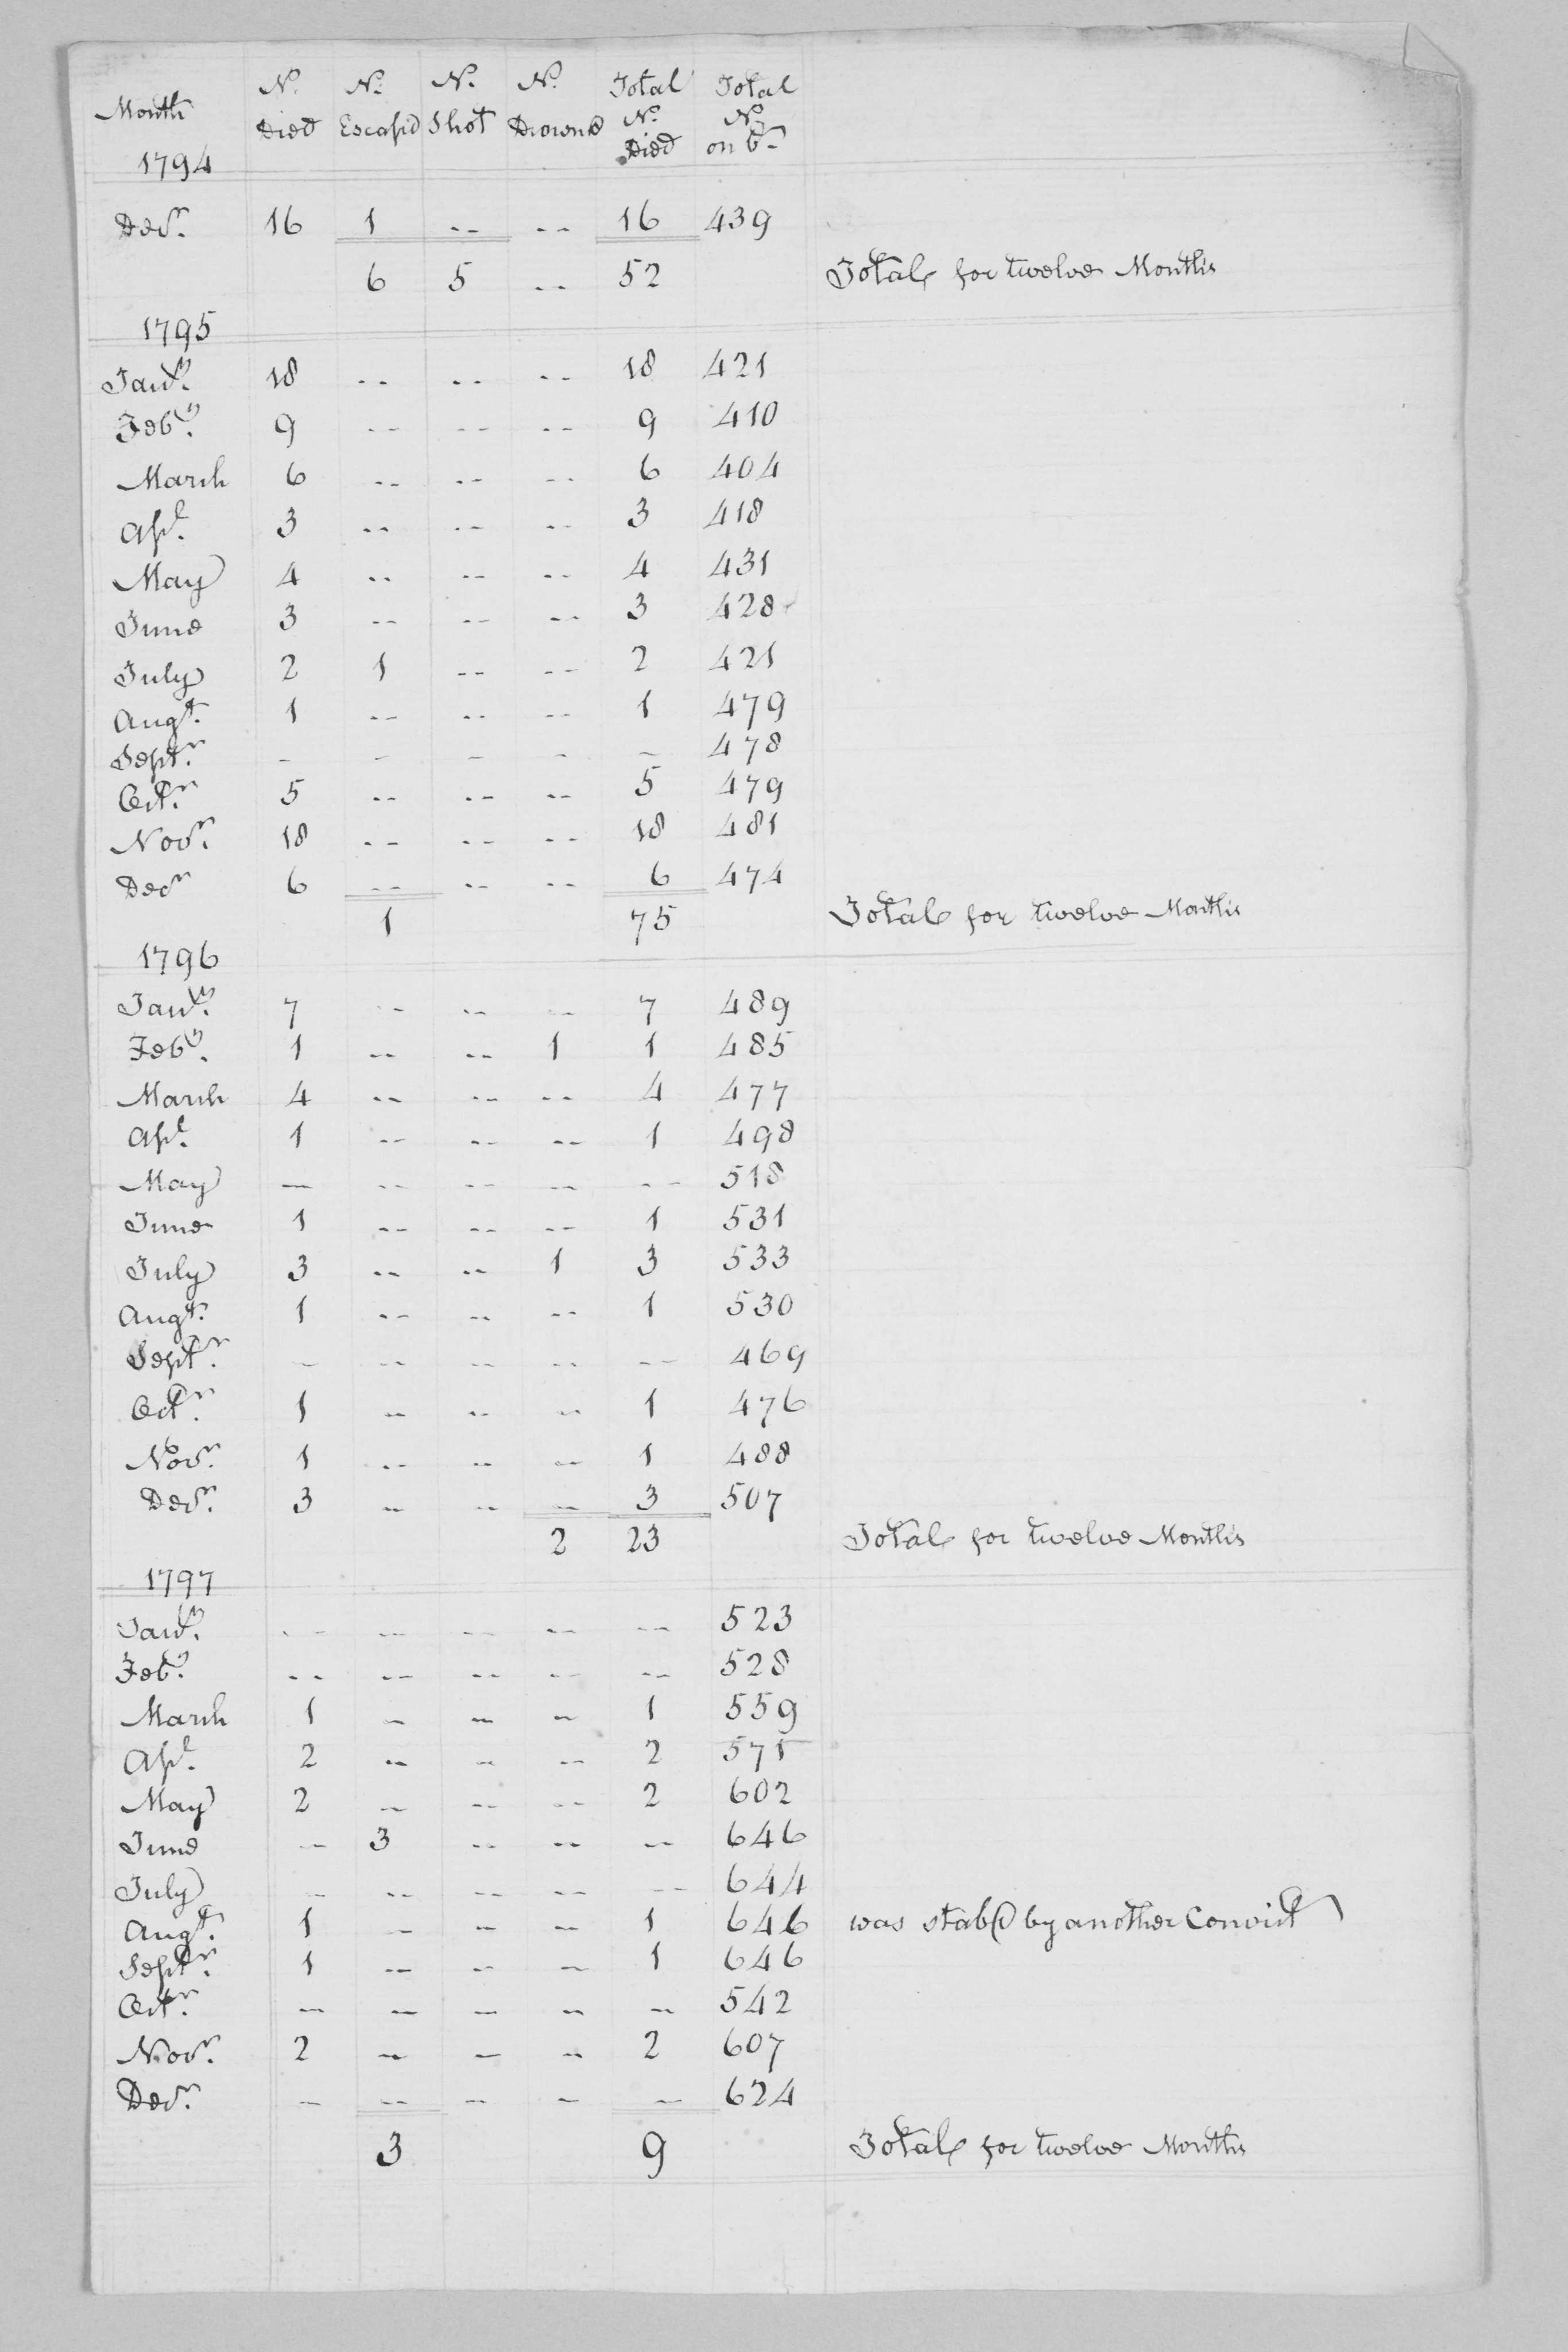

In [10]:
image_df_2 = spark.read.format("binaryFile").load(imagePath_2)#.limit(1)

display_images(BinaryToImage().transform(image_df_2), "image")

In [11]:
img_to_hocr_handwritten = ImageToTextV2().pretrained("ocr_base_handwritten_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setUseGPU(False)

pipeline_2 = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr_handwritten,
    hocr_to_table
])

result_2 = pipeline.transform(image_df_2).cache()
display(result_2)

+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+
|        text_regions|                path|    modificationTime| length|pagenum|         table_image|       table_regions|               image|  image_with_regions|                hocr|positions|              tables|exception|table_index|
+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+
|[{0, 0, 979.1998,...|file:/home/jose/s...|2023-05-26 14:22:...|4786163|      0|{file:/home/jose/...|{0, 0, 140.0, 106...|{file:/home/jose/...|{file:/home/jose/...|<div title="bbox ...|   [null]|{{0, 0, 0.0, 0.0,...|     null|          0|
+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-----------+

In [12]:
display_tables(result_2, table_col = "tables", table_index_col = "table_index")

Filename: cTDaR_t00192.jpg
Page: 0
Table: 0
Number of Columns: 3


## Additional input from cells detector


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_3/table1.png
    Resolution: 0 dpi
    Width: 850 px
    Height: 411 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


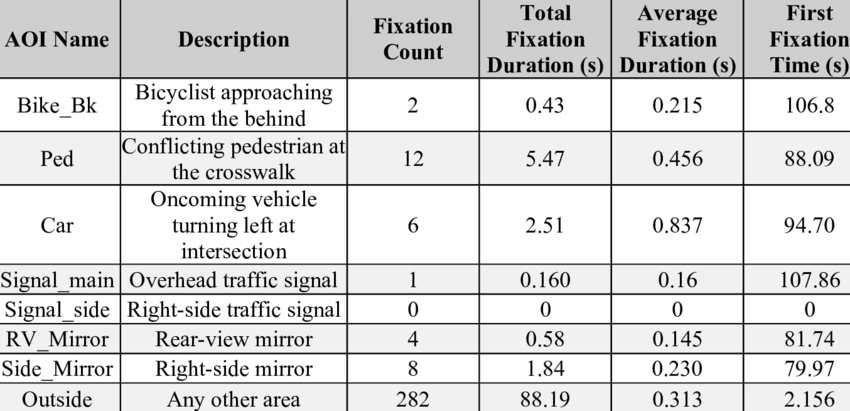

In [13]:
image_df_3 = spark.read.format("binaryFile").load(imagePath_3)

display_images(BinaryToImage().transform(image_df_3), "image")

In [14]:
binary_to_image = BinaryToImage()

img_to_hocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

cell_detector = ImageDocumentRegionDetector() \
    .pretrained("region_cell_detection", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("cells") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.red)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables") \
    .setUseCellsCol("cells")

pipeline_3 = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    cell_detector,
    draw_regions,
    hocr_to_table
])

result_3 = pipeline_3.transform(image_df_3).cache()
display(result_3)

region_cell_detection download started this may take some time.
Approximate size to download 23.1 MB


+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|               image|                path|    modificationTime|length|pagenum|                hocr|               cells|  image_with_regions|              tables|exception|table_index|
+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|{file:/home/jose/...|file:/home/jose/s...|2023-12-26 18:02:...| 67152|      0|  <div class='ocr...|[{0, 0, 122.0, 13...|{file:/home/jose/...|{{0, 0, 0.0, 0.0,...|     null|          0|
+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+---------+-----------+


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images_hocr_3/table1.png
    Resolution: 0 dpi
    Width: 850 px
    Height: 411 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


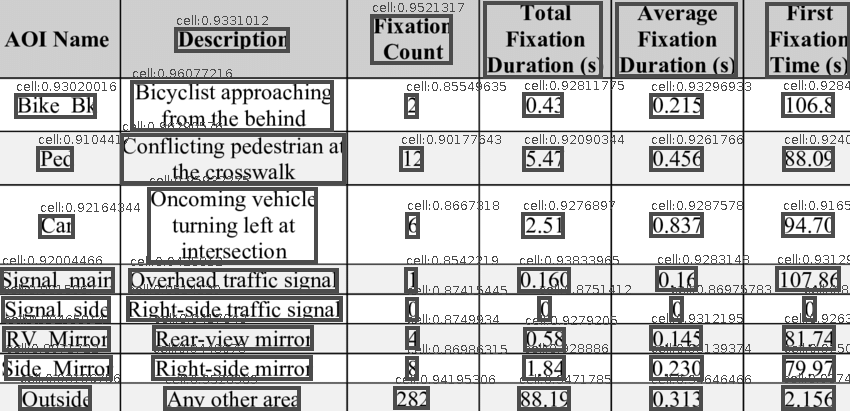

In [15]:
display_images(result_3, "image_with_regions")

In [16]:
display_tables(result_3, table_col = "tables", table_index_col = "table_index")

Filename: table1.png
Page: 0
Table: 0
Number of Columns: 6


## Using with LightPipeline

In [4]:
from sparkocr.base import LightPipeline

binary_to_image = BinaryToImage()

img_to_hocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

cell_detector = ImageDocumentRegionDetector() \
    .pretrained("region_cell_detection", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("cells") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.red)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables") \
    .setUseCellsCol("cells")

pipeline_4 = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    cell_detector,
    draw_regions,
    hocr_to_table
])

image_df_4 = spark.read.format("binaryFile").load(imagePath_3)
lp = LightPipeline(pipeline_4)
result_4 = lp.transform(image_df_4).cache()
display_tables(result_4, table_col = "tables", table_index_col = "table_index")

region_cell_detection download started this may take some time.
Approximate size to download 23.1 MB
Filename: table1.png
Page: 0
Table: 0
Number of Columns: 6
